In [52]:
import torch
import torch.nn as nn
import ignite
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import pandas as pd

import plotly
# plotly.offline.init_notebook_mode(connected=True)

from sklearn.decomposition import PCA

In [37]:
config = {
    "batch_size": 32,
    "lr": 0.00001,
    "momentum": 0.9
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 128)
        
        self.projection_net = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = self.projection_net(x)
        return output, x


In [39]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dset = MNIST('/home/gvisona/Projects/tmp_data', train=True, download=True,
                   transform=transform)
val_dset = MNIST('/home/gvisona/Projects/tmp_data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=config["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=config["batch_size"], shuffle=False)

print(len(train_loader))
print(len(val_loader))

1875
313


In [40]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])

In [41]:

def hypershperical_cosine_margin_similarity(emb1, emb2, s=1.0, m=0.5):
    # Embs must be normalized
    # emb1 = emb1 / emb1.norm(dim=1)[:, None]
    # emb2 = emb2 / emb2.norm(dim=1)[:, None]    
    c = torch.mm(emb1, emb2.transpose(1, 0))
    c -= m
    return torch.exp(s*c)


class CustomCMT_Loss(nn.Module):
    def __init__(self, s=1.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m
        
        
    def forward(self, embeddings, labels):
        emb_norm = embeddings.norm(dim=1)
        l2_weight = 0.01
        
        embeddings = embeddings / embeddings.norm(dim=1)[:, None]
        
        ix = (labels==1)
        pos_embs = embeddings[ix]
        neg_embs = embeddings[~ix]
        
        pos_sims = hypershperical_cosine_margin_similarity(pos_embs, pos_embs, s=self.s, m=self.m)
        # pos_sims -= (math.e * torch.eye(len(pos_sims), device=pos_sims.device))
        neg_sims = hypershperical_cosine_margin_similarity(pos_embs, neg_embs, s=self.s, m=0.0)       
        
        easy_pos_sims, _ = torch.max(pos_sims - (math.e * torch.eye(len(pos_sims), device=pos_sims.device)), dim=1)
        hard_neg_sims, _ = torch.max(neg_sims, dim=1)
        
        cmt_loss = torch.mean(-1* torch.log(easy_pos_sims/(easy_pos_sims+hard_neg_sims)))
        
        hypersphere_reg = torch.mean(torch.square(emb_norm-self.s))
        loss = cmt_loss #+ l2_weight*hypersphere_reg
        
        logs = {"loss": loss.item(), "cmt_loss": cmt_loss.item(), 'hypersphere_reg': hypersphere_reg.item()}
        return loss, logs

In [50]:
class CustomCMT_AllTriplets_Loss(nn.Module):
    def __init__(self, s=1.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m
        
        
    def forward(self, embeddings, labels):
        emb_norm = embeddings.norm(dim=1)
        l2_weight = 0.01
        
        embeddings = embeddings / embeddings.norm(dim=1)[:, None]
        
        ix = (labels==1)
        pos_embs = embeddings[ix]
        neg_embs = embeddings[~ix]
        
        pos_sims = hypershperical_cosine_margin_similarity(pos_embs, pos_embs, s=self.s, m=self.m)
        neg_sims = hypershperical_cosine_margin_similarity(pos_embs, neg_embs, s=self.s, m=0.0)       
        
        p_ixs = torch.triu_indices(*pos_sims.shape, offset=1)
        pos_cos_sims = pos_sims[p_ixs[0], p_ixs[1]]
        
        n_ixs = torch.triu_indices(*neg_sims.shape, offset=0)
        neg_cos_sims = neg_sims[n_ixs[0], n_ixs[1]]
        
        
        
        cmt_loss = -1* torch.log(pos_cos_sims/(pos_cos_sims+neg_cos_sims.view(-1,1)))
        cmt_loss = torch.mean(cmt_loss)
        
        hypersphere_reg = torch.mean(torch.square(emb_norm))#-self.s))
        loss = cmt_loss #+ l2_weight*hypersphere_reg
        
        logs = {"loss": loss.item(), "cmt_loss": cmt_loss.item(), 'hypersphere_reg': hypersphere_reg.item()}
        return loss, logs

In [51]:
n_iter = -1
validate_every = 1000
MAX_ITER = 10000
criterion = CustomCMT_AllTriplets_Loss()
training_logs = []
val_logs = []

loss_logs = []
pbar = tqdm(total=MAX_ITER)
while n_iter<MAX_ITER:
    for i, batch in enumerate(train_loader):
        batch_data, labels = batch
        projections, _ = model(batch_data)
        binary_labels = torch.where(labels==3, 1, -1)
        if (binary_labels>0).sum()<2:
            continue
        loss, train_logs = criterion(projections, binary_labels)
        train_logs["n_batch"] = n_iter
        training_logs.append(train_logs.copy())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        n_iter += 1
        epoch_val_losses = []
        if n_iter % validate_every==0:
            for i, batch in enumerate(val_loader):
                batch_data, labels = batch
                projections, _ = model(batch_data)
                binary_labels = torch.where(labels==3, 1, -1)
                if (binary_labels>0).sum()<2:
                    continue
                loss, logs = criterion(projections, binary_labels)
                loss_logs.append(logs)
                epoch_val_losses.append(loss.item())
            avg_val_loss = np.mean(epoch_val_losses)
            val_logs.append({"n_batch": n_iter, "val_loss": avg_val_loss})
            
            pbar.set_description("Train loss: {:.3f} - Val loss {:.3f}".format(train_logs["loss"], avg_val_loss))
        pbar.update(1)

pbar.close()
val_logs = pd.DataFrame(val_logs)
training_logs = pd.DataFrame(training_logs)
training_logs

  0%|          | 0/10000 [00:00<?, ?it/s]

,loss,cmt_loss,hypersphere_reg,n_batch
0,1.011588,1.011588,0.059833,-1
1,0.966058,0.966058,0.060990,0
2,0.974646,0.974646,0.062549,1
3,0.974038,0.974038,0.060286,2
4,0.973850,0.973850,0.061674,3
...,...,...,...,...
11219,0.329920,0.329920,0.032110,11218
11220,0.538882,0.538882,0.040597,11219
11221,0.252577,0.252577,0.061788,11220
11222,0.982385,0.982385,0.041613,11221


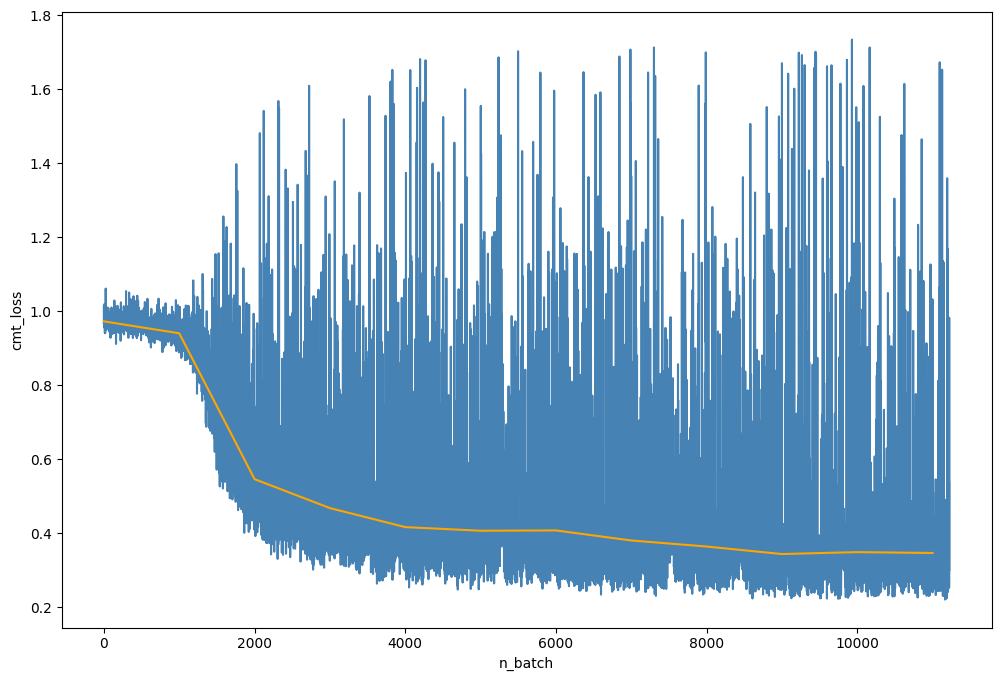

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(training_logs, x="n_batch", y="cmt_loss", color="steelblue", ax=ax)
sns.lineplot(val_logs, x="n_batch", y="val_loss", color="orange", ax=ax)
plt.show()

In [61]:
val_embeddings = []
val_projections = []
val_labels = []

for i, batch in tqdm(enumerate(val_loader)):
    batch_data, labels = batch
    projections, embeddings = model(batch_data)
    val_embeddings.append(embeddings.detach().numpy())
    val_projections.append(projections.detach().numpy())
    binary_labels = torch.where(labels==3, 1, -1)
    val_labels.append(binary_labels.detach().numpy())

        
val_embeddings = np.concatenate(val_embeddings, axis=0)
val_projections = np.concatenate(val_projections, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

0it [00:00, ?it/s]

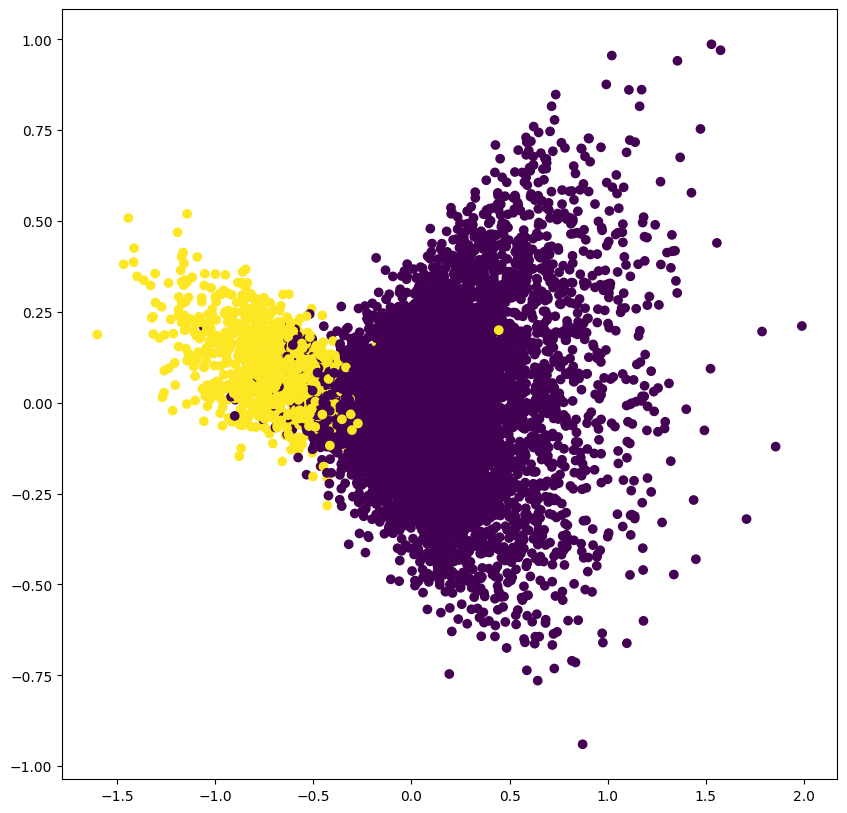

In [62]:
proj_pca_embeddings = PCA(n_components=2).fit_transform(val_embeddings)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(proj_pca_embeddings[:,0], proj_pca_embeddings[:,1], c=val_labels)
plt.show()


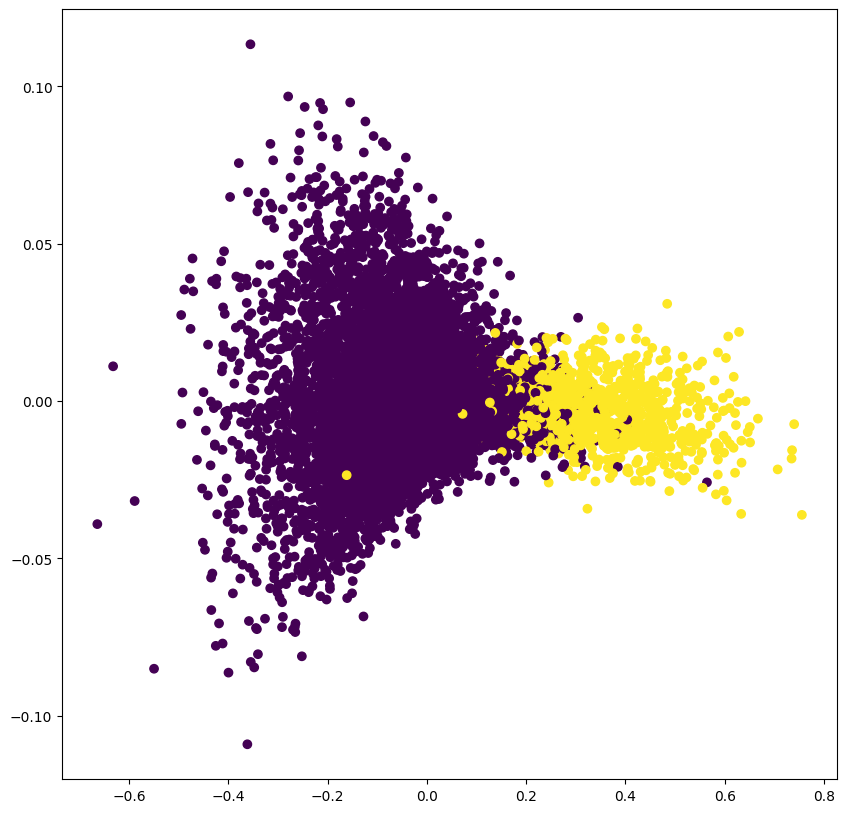

In [63]:
proj_pca_projections = PCA(n_components=2).fit_transform(val_projections)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(proj_pca_projections[:,0], proj_pca_projections[:,1], c=val_labels)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(training_logs, x="n_batch", y="cmt_loss", color="steelblue", ax=ax)
sns.lineplot(val_logs, x="n_batch", y="val_loss", color="orange", ax=ax)
plt.show()

In [9]:
def cmt_loss(t1, t2, s=1.0, m=0.0):
    e1 = np.exp(s*(np.cos(t1)-m))
    e2 = np.exp(s*np.cos(t2))
    loss = -1 * np.log(e1/(e1+e2))
    return loss

In [10]:
cmt_loss(0.1, 1.2)

0.4260414279673197

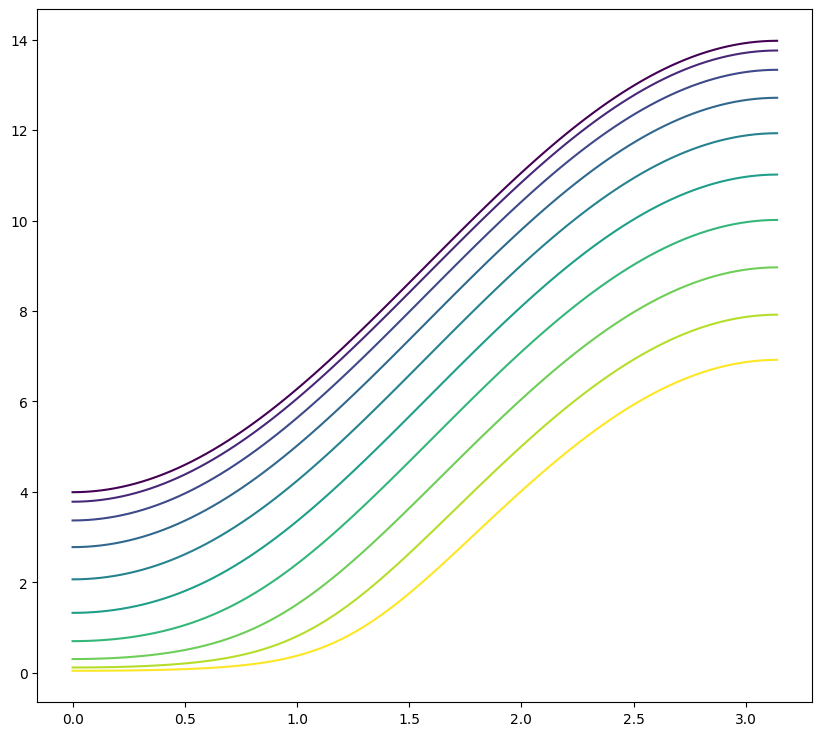

In [11]:
cmap = plt.get_cmap("viridis", 10)

xx = np.linspace(0.0, 3.14, 101)
t2_vals = np.linspace(0.1 , 2.0, 10)

fig, ax = plt.subplots(figsize=(10, 9))
for i, t2 in enumerate(t2_vals):
    color = cmap(i)
    yy = cmt_loss(xx, t2, s=5.0, m=0.8)
    ax.plot(xx, yy, c=color)
    
plt.show()

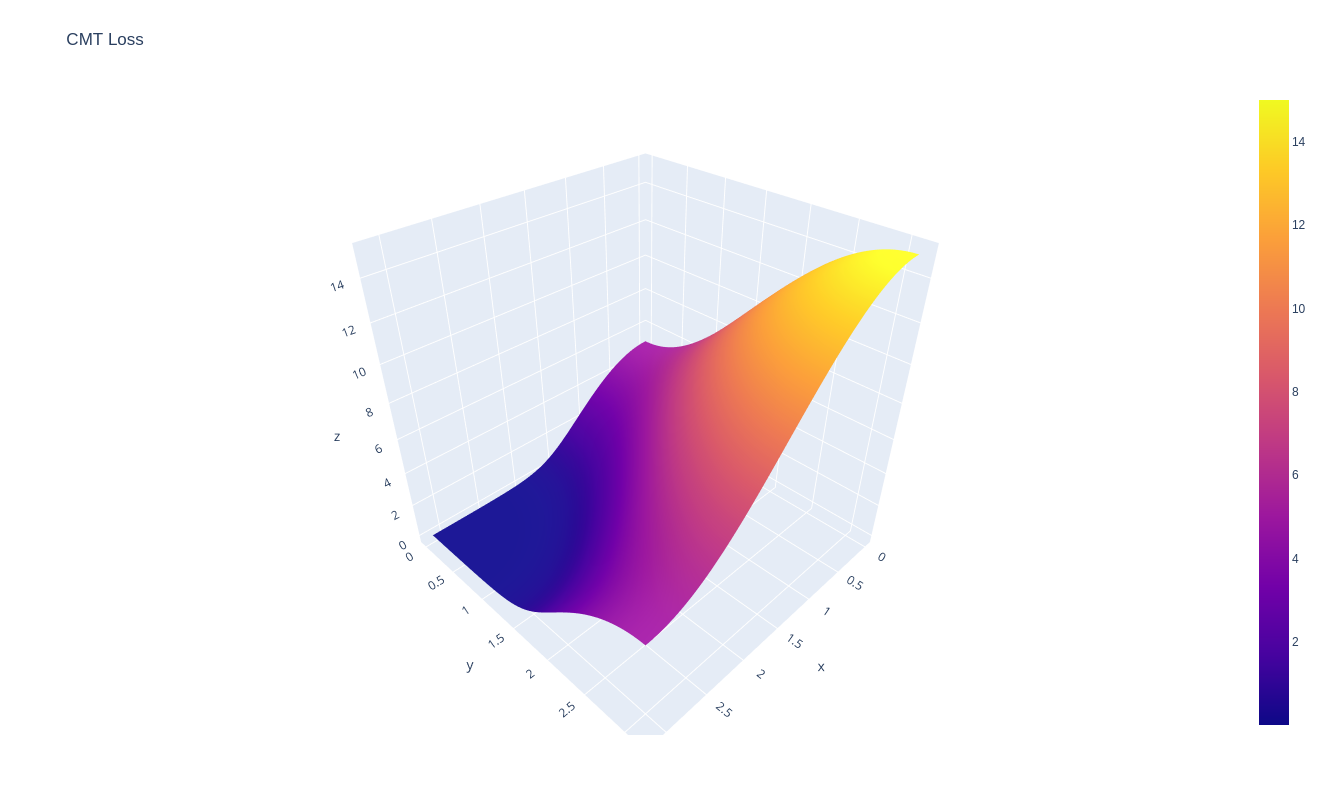

In [25]:
Z = np.zeros((len(xx), len(xx)))
for i, t1 in enumerate(xx):
    for j, t2 in enumerate(xx):
        Z[i, j]=cmt_loss(t1, t2, s=5.0, m=1.0)

fig = go.Figure(data=[go.Surface(z=Z, x=xx, y=xx)])

fig.update_layout(title='CMT Loss', autosize=True,
                  width=1000, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [6]:
Z.shape

(101, 101)

In [31]:
aa = torch.tensor([2.0, 4, 6, 8])
bb = torch.tensor([1, 2, 3.0, 4]).reshape(-1, 1)

In [33]:
aa/bb

tensor([[2.0000, 4.0000, 6.0000, 8.0000],
        [1.0000, 2.0000, 3.0000, 4.0000],
        [0.6667, 1.3333, 2.0000, 2.6667],
        [0.5000, 1.0000, 1.5000, 2.0000]])